In [1]:
# import libraries
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

# specify name of csv file
filename = 'final_data.csv'

# open csv file
df = pd.read_csv(filename)

df.head()

,Unnamed: 0.1,Unnamed: 0,PC6,Date,District,ConnectionTimeHours,kWh,effective_charging_hrs,power,MaxOccupancy,MaxPower,Blocked_kWh,Total,Vattenfall,Allego,Equans,EvBox,Nuon,WDS,Engie,Pitpoint,Ecotap,ChargeSocket_ID_count,IsFastCharger,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,index,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore
0,0,0,1011AB,2022-01-03,Centrum,67.59,125.8,22.789855,33.12,288.0,1589.76,373.0968,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.433333,3.133333,4.3,4.433333,3.233333,2.9,2.716667,2.966667,4.0,3.716667,4.216667,3.933333,3.0,2.95,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.168478,2.133333,3.3,3.433333,3.0,1.82029,1.519928,0.776087,2.0,1.001449,1.533333,2.0,2.0,1.966667,1463.96,-648.8208,220.41,0.079131,1.408125,1,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034
1,66,66,1011AC,2022-01-03,0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.00,0.000000,0.000000,1,0.0,0.0,1.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034
2,132,18084,1011AD,2022-01-03,0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.00,0.000000,0.000000,1,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034
3,198,18150,1011AE,2022-01-03,0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.00,0.000000,0.000000,1,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,2

In [3]:
# number of unique values in first column
print(df[df.columns[0]].nunique())

# number of unique values in second column
print(df[df.columns[1]].nunique())

# one column of index can be dropped, since it is not the correct index

1219812
1219812


In [4]:
# create a new column called "WeekIndex" which first lists all unique values of the date column, then assigns a number to each unique value starting from 0 for the lowest value
df['WeekIndex'] = df['Date'].astype('category').cat.codes

In [5]:
# print first 5 rows
df.rename(columns={df.columns[0]: 'index_to_drop', df.columns[1]: 'RowIndex'},inplace=True)

# remove "index" column, since this is not the correct index
df.drop(columns=["index_to_drop"], inplace=True)

# remove "index" column, since this is not the correct index
df.drop(columns=["index"], inplace=True)

In [6]:
# rename column "IsFastCharger" to "FastChargerNumber"
df.rename(columns={"IsFastCharger": "FastChargerNumber"}, inplace=True)

In [7]:
# unit test that each row has a unique index
assert df['RowIndex'].nunique() == len(df.index)

# convert 'RowIndex' column to integer
df['RowIndex'] = df['RowIndex'].astype(int)

# set the 'RowIndex' column to index
df = df.set_index("RowIndex")

In [8]:
# cut district column and insert as last column
df['District-encoded'] = df['District'].str[0:2]

# count unique categories in District column -> 11
print(df["District-encoded"].nunique())

# encode categorical variable "District" with binary encoding
# documentation: https://contrib.scikit-learn.org/category_encoders/binary.html
from category_encoders.binary import BinaryEncoder
encoder = BinaryEncoder(cols=['District-encoded'])
encoder.fit(df)
df = encoder.transform(df)

9


In [9]:
# count unique categories in ZipCode "PC6" column
print(df["PC6"].nunique())

# retrieve PC4 from PC6, that is the first 4 digits of the 6 digit zip code
df["PC4"] = df["PC6"].astype(str).str[:4]
df["PC6-encoded"] = df["PC6"]
df["PC4-encoded"] = df["PC4"]
print(df["PC4-encoded"].nunique())

# encode categorical variable "PC4" with binary encoding
encoder = BinaryEncoder(cols=['PC4-encoded'])
encoder.fit(df)
df = encoder.transform(df)

# encode categorical variable "PC4" with binary encoding
encoder = BinaryEncoder(cols=['PC6-encoded'])
encoder.fit(df)
df = encoder.transform(df)

18482
81


In [10]:
df.head()

,PC6,Date,District,ConnectionTimeHours,kWh,effective_charging_hrs,power,MaxOccupancy,MaxPower,Blocked_kWh,Total,Vattenfall,Allego,Equans,EvBox,Nuon,WDS,Engie,Pitpoint,Ecotap,ChargeSocket_ID_count,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,WeekIndex,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC4,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1011AB,2022-01-03,Centrum,67.59,125.8,22.789855,33.12,288.0,1589.76,373.0968,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.433333,3.133333,4.3,4.433333,3.233333,2.9,2.716667,2.966667,4.0,3.716667,4.216667,3.933333,3.0,2.95,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.168478,2.133333,3.3,3.433333,3.0,1.82029,1.519928,0.776087,2.0,1.001449,1.533333,2.0,2.0,1.966667,1463.96,-648.8208,220.41,0.079131,1.408125,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,0,0,1,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
66,1011AC,2022-01-03,0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.00,0.000000,0.000000,0.0,0.0,1.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,0,1,0,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
18084,1011AD,2022-01-03,0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080

In [11]:
# all columns (including provider columns) that are not in the above lists are unknown variables
providers = ["Total", "Vattenfall", "Allego", "Equans", "EvBox", "Nuon", "WDS", "Pitpoint", "Ecotap", "Engie"]

# create a new column called "number of chargers" which is the sum of the values of the columns which names are stored in the providers list
df['number_of_chargers'] = df[providers].sum(axis=1)

providers.append("number_of_chargers")

# reverse list
providers = providers[::-1]

In [12]:
# rename column kWh to Consumed_kWh
df.rename(columns={"kWh": "Consumed_kWh"}, inplace=True)

In [13]:
# split columns into several groups: identifiers, target variables, know_variables, unknown_variables, purely_descriptive_variables

# reorder columns in the following order:
identifiers = ["PC6", "Date"]
know_variables = ["WeekIndex", "MaxPower"]
target_variables = ["Consumed_kWh", "Blocked_kWh"]

purely_descriptive_variables = ["ChargeSocket_ID_count", "ConnectionTimeHours", "power", "effective_charging_hrs", "MaxOccupancy", "SpareCap_Effective", "SpareCap_Occup_kWh", "SpareCap_Hrs", "Effective%", "Occupancy_kwh%"]


unknown_variables = [col for col in df.columns if col not in identifiers + target_variables + know_variables + providers+ purely_descriptive_variables]
unknown_variables = providers + unknown_variables

print(len(identifiers + target_variables + know_variables + purely_descriptive_variables + unknown_variables))

132


In [14]:
# sort df columns in the following order: identifiers, target variables, know_variables, unknown_variables, purely_descriptive_variables
df = df[identifiers + know_variables + target_variables + unknown_variables + purely_descriptive_variables]

In [15]:
# inspect df without the purely_descriptive_variables
df[identifiers + know_variables + target_variables + unknown_variables].head()

,PC6,Date,WeekIndex,MaxPower,Consumed_kWh,Blocked_kWh,number_of_chargers,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,District,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC4,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1011AB,2022-01-03,0,1589.76,125.8,373.0968,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,Centrum,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.433333,3.133333,4.3,4.433333,3.233333,2.9,2.716667,2.966667,4.0,3.716667,4.216667,3.933333,3.0,2.95,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.168478,2.133333,3.3,3.433333,3.0,1.82029,1.519928,0.776087,2.0,1.001449,1.533333,2.0,2.0,1.966667,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,0,1,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
66,1011AC,2022-01-03,0,0.00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,1,0,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
18084,1011AD,2022-01-03,0,0.00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,1,0,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
18150,1011AE,2022-01-03,0,0.00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000

In [16]:
# check missing values: show only columns where missing values >0 and their count per column
print(df.isna().sum()[df.isna().sum() > 0])

Series([], dtype: int64)


In [17]:
# sort df by date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['PC6', 'Date'])

In [18]:
# add week of year column, extracted from date column
df["WeekOfYear"] = pd.to_datetime(df['Date']).dt.isocalendar().week

# month of year
df["MonthOfYear"] = pd.to_datetime(df['Date']).dt.month

# sine and cosine week of year -> to introduce cyclical nature of months
# sine & cosine week of year
# cosine week of year
df["CosWeekOfYear"] = np.cos(2*np.pi*df["WeekOfYear"]/52)

# sine week of year
df["SinWeekOfYear"] = np.sin(2*np.pi*df["WeekOfYear"]/52)

# cosine month of year
df["CosMonthOfYear"] = np.cos(2*np.pi*df["MonthOfYear"]/12)

# sine month of year
df["SinMonthOfYear"] = np.sin(2*np.pi*df["MonthOfYear"]/12)

# drop week of year, month of year columns
df.drop(columns=["WeekOfYear", "MonthOfYear"], inplace=True)

In [19]:
df.head()

,PC6,Date,WeekIndex,MaxPower,Consumed_kWh,Blocked_kWh,number_of_chargers,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,District,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC4,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6,ChargeSocket_ID_count,ConnectionTimeHours,power,effective_charging_hrs,MaxOccupancy,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,CosWeekOfYear,SinWeekOfYear,CosMonthOfYear,SinMonthOfYear
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1011AB,2022-01-03,0,1589.76,125.80,373.0968,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,Centrum,0.0,2.00,2.000000,2.0,2.0,2.000000,2.0,2.000000,2.000000,2.000000,2.000000,2.433333,3.133333,4.300000,4.433333,3.233333,2.900000,2.716667,2.966667,4.000000,3.716667,4.216667,3.933333,3.000000,2.950000,2.00,2.000000,2.000000,2.0,2.000000,2.0,2.000000,2.000000,2.000000,2.000000,2.168478,2.133333,3.300000,3.433333,3.000000,1.820290,1.519928,0.776087,2.000000,1.001449,1.533333,2.000000,2.000000,1.966667,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,0,1,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,10.0,67.59,33.12,22.789855,288.0,1463.96,-648.8208,220.41,0.079131,1.408125,0.992709,0.120537,0.866025,0.5
1,1011AB,2022-01-10,1,3709.44,457.95,904.3416,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,Centrum,0.0,3.75,4.000000,4.0,4.0,4.000000,4.0,4.183333,5.150000,7.233333,10.333333,12.083333,13.683333,12.750000,12.233333,12.783333,9.116667,6.583333,7.350000,6.016667,5.633333,5.000000,3.933333,3.000000,2.950000,3.75,4.000000,3.675725,3.0,3.000000,3.0,3.183333,4.150000,5.975362,8.866667,10.402536,9.167754,6.113043,6.038406,4.959058,2.844928,2.850000,5.583696,4.716667,4.569928,4.000000,2.702899,1.682246,0.983333,0.0,0.0,0.0,0.0,5.5393,5.3554,1.4589,0.0,0.0,0.0,11.9398,367.0,187.0,475.0,540.0,2065.0,1645.0,1080.0,6200.0,45.0,28.0,27.1,49.3,50.8,23.0,26.2,47.6,0.034,0,0,0,1,1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,26.0,163.83,77.28,82.961957,672.0,3251.49,-8951.3424,508.17,0.123455,3.413125,0.970942,0.239316,0.866025,0.5
2,1011AB,2022-01-17,2,3709.44,525.80,1298.3040,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,Ce

In [20]:
# count number of remaining rows
print(df.shape)

(1219812, 136)


In [21]:
# load cleaned data
# df = pd.read_csv(filename.split('.')[0] + '_cleaned.csv')

# create new column as concatenation of PC6 and WeekIndex columns
df['PC6_WeekIndex'] = df['PC6'].astype(str) + df['WeekIndex'].astype(str)

# move this column to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]

# count duplicates in PC6_WeekIndex column
df['PC6_WeekIndex'].duplicated().sum()

0

In [22]:
# identifier columns
identifier_columns = ["PC6", "Date", "PC6_WeekIndex"]

# target columns
target_columns = ["Consumed_kWh", "Blocked_kWh"]

# duplicate target columns and add them to the data frame
duplicate_target_columns = [col + "_lag" for col in target_columns]
df[duplicate_target_columns] = df[target_columns]

# enrich data with lagged values of target columns
lagged_columns = ["MaxPower", "number_of_chargers"]

# specify time columns
time_columns = ["WeekIndex", "SinWeekOfYear", "CosWeekOfYear", "SinMonthOfYear", "CosMonthOfYear"]

# descriptive columns
descriptive_columns = ["ChargeSocket_ID_count", "ConnectionTimeHours", "power", "effective_charging_hrs", "MaxOccupancy", "SpareCap_Effective", "SpareCap_Occup_kWh", "SpareCap_Hrs", "Effective%", "Occupancy_kwh%", "PC4", "District"]

# encoded columns -> include "encoded" string in column name
encoded_columns = [col for col in df.columns if "encoded" in col]

all_columns = identifier_columns + target_columns + lagged_columns + time_columns + descriptive_columns + encoded_columns

# show columns that are not in the above lists
numerical_features = ([col for col in df.columns if col not in all_columns])

# print lists of columns
print(f"identifier_columns [{len(identifier_columns)}]: {identifier_columns}")
print(f"target_columns [{len(target_columns)}]: {target_columns}")
print(f"duplicate_target_columns [{len(duplicate_target_columns)}]: {duplicate_target_columns}")
print(f"lagged_columns [{len(lagged_columns)}]: {lagged_columns}")
print(f"time_columns [{len(time_columns)}]: {time_columns}")
print(f"numerical_features [{len(numerical_features)}]: {numerical_features}")
print(f"encoded_columns [{len(encoded_columns)}]: {encoded_columns}")
print(f"descriptive_columns [{len(descriptive_columns)}]: {descriptive_columns}")

# store all lists in a dictionary
column_lists = {"identifier_columns": identifier_columns,
                "target_columns": target_columns,
                "duplicate_target_columns": duplicate_target_columns,
                "lagged_columns": lagged_columns,
                "time_columns": time_columns,
                "numerical_features": numerical_features,
                "encoded_columns": encoded_columns,
                "descriptive_columns": descriptive_columns}

# pickle the dictionary
import pickle
with open(filename.split('.')[0] + '_column_lists.pickle', 'wb') as handle:
    pickle.dump(column_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

all_columns += numerical_features

identifier_columns [3]: ['PC6', 'Date', 'PC6_WeekIndex']
target_columns [2]: ['Consumed_kWh', 'Blocked_kWh']
duplicate_target_columns [2]: ['Consumed_kWh_lag', 'Blocked_kWh_lag']
lagged_columns [2]: ['MaxPower', 'number_of_chargers']
time_columns [5]: ['WeekIndex', 'SinWeekOfYear', 'CosWeekOfYear', 'SinMonthOfYear', 'CosMonthOfYear']
numerical_features [89]: ['Engie', 'Ecotap', 'Pitpoint', 'WDS', 'Nuon', 'EvBox', 'Equans', 'Allego', 'Vattenfall', 'Total', 'FastChargerNumber', '0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24', 'effective_charging_hrs0-1', 'effective_charging_hrs1-2', 'effective_charging_hrs2-3', 'effective_charging_hrs3-4', 'effective_charging_hrs4-5', 'effective_charging_hrs5-6', 'effective_charging_hrs6-7', 'effective_charging_hrs7-8', 'effective_charging_hrs8-9', 'effective_charging_hrs9-10', 'effective_charging_hrs10-11', 

In [23]:
# reorder df in the following order: identifier_columns, target_columns, lagged_columns, time_columns, numerical_features, encoded_columns, descriptive_columns
df = df[all_columns]

In [24]:
# scale all columns that in the following lists: lagged_columns, time_columns, numerical_features
columns_to_scale = lagged_columns + time_columns + numerical_features

In [25]:
# for columns to scale, check min max values
df[columns_to_scale].describe()

,MaxPower,number_of_chargers,WeekIndex,SinWeekOfYear,CosWeekOfYear,SinMonthOfYear,CosMonthOfYear,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,Consumed_kWh_lag,Blocked_kWh_lag
count,1.219812e+06,1.219812e+06,1.219812e+06,1219812.0,1219812.0,1.219812e+06,1.219812e+06,1219812.0,1219812.0,1.219812e+06,1.219812e+06,1219812.0,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06,1.219812e+06
mean,3.398915e+02,9.667605e-01,3.250000e+01,0.147859,0.11584,1.530012e-01,8.833526e-02,0.0,0.0,4.771883e-02,9.681820e-04,0.0,3.889944e-03,8.443924e-05,8.034025e-03,8.960586e-01,1.000646e-02,1.000318e-02,1.116755e+00,1.118663e+00,1.126289e+00,1.129311e+00,1.128758e+00,1.121998e+00,1.099684e+00,1.033919e+00,9.091218e-01,8.488508e-01,8.268110e-01,8.049214e-01,7.860149e-01,7.749602e-01,7.633328e-01,7.624436e-01,7.792132e-01,8.170148e-01,8.968834e-01,9.709009e-01,1.011355e+00,1.041918e+00,1.066948e+00,1.071208e+00,1.115661e+00,1.113072e+00,1.113102e+00,1.108280e+00,1.100316e+00,1.086134e+00,1.056008e+00,9.809418e-01,8.439721e-01,7.611607e-01,7.053863e-01,6.489423e-01,6.046419e-01,5.726779e-01,5.436215e-01,5.286822e-01,5.338139e-01,5.624580e-01,6.184376e-01,6.397731e-01,6.181410e-01,5.906487e-01,5.633786e-01,5.224733e-01,1.731414e-03,1.893734e-03,9.522779e-03,5.951737e-04,2.913148e+00,1.993055e+01,1.285364e+00,3.731341e+00,1.798465e+00,3.350298e-01,5.474455e+00,1.071512e+02,8.775749e+01,1.275447e+03,1.270370e+03,2.721666e+03,2.601404e+03,1.747252e+03,7.381490e+03,4.692569e+01,2.933728e+01,2.256116e+01,4.653349e+01,5.613638e+01,2.523452e+01,1.746324e+01,4.186145e+01,-8.851023e-02,3.844468e+01,1.418745e+0

In [26]:
# create scaler object
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit scaler object to data
scaler.fit(df[columns_to_scale])

# transform data
df[columns_to_scale] = scaler.transform(df[columns_to_scale])

In [27]:
# for columns to scale, check min max values
df[columns_to_scale].describe().loc[['min', 'max']]

,MaxPower,number_of_chargers,WeekIndex,SinWeekOfYear,CosWeekOfYear,SinMonthOfYear,CosMonthOfYear,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,Consumed_kWh_lag,Blocked_kWh_lag
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# Lists of column names to convert to float64
column_lists = {
    "target_columns": target_columns,
    "duplicate_target_columns": duplicate_target_columns,
    "lagged_columns": lagged_columns,
    "time_columns": time_columns,
    "numerical_features": numerical_features,
    "encoded_columns": encoded_columns,
}

# Loop through each list of column names in the dictionary
for col_list in column_lists.values():
    for col in col_list:
        # Only try to convert the column to float64 if it exists in the DataFrame
        if col in df.columns:
            df[col] = df[col].astype('float64')

In [29]:
df.dtypes

PC6                                              object
Date                                     datetime64[ns]
PC6_WeekIndex                                    object
Consumed_kWh                                    float64
Blocked_kWh                                     float64
                                              ...      
2019.0_assets_81_to_100_percent                 float64
2019.0_assets_average                           float64
2019.0_Gemiddelde SES WOA totaalscore           float64
Consumed_kWh_lag                                float64
Blocked_kWh_lag                                 float64
Length: 139, dtype: object

In [30]:
# keep only first 10000 rows for testing purposes
df = df.head(3000)

# inspect data
# show all columns

df.head()

,PC6,Date,PC6_WeekIndex,Consumed_kWh,Blocked_kWh,MaxPower,number_of_chargers,WeekIndex,SinWeekOfYear,CosWeekOfYear,SinMonthOfYear,CosMonthOfYear,ChargeSocket_ID_count,ConnectionTimeHours,power,effective_charging_hrs,MaxOccupancy,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,PC4,District,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,Consumed_kWh_lag,Blocked_kWh_lag
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1011AB,2022-01-03,1011AB0,125.80,373.0968,0.007670,0.018634,0.000000,0.560268,0.996354,0.75,0.933013,10.0,67.59,33.12,22.789855,288.0,1463.96,-648.8208,220.41,0.079131,1.408125,1011,Centrum,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018634,0.0,0.0,0.004332,0.004361,0.004379,0.004421,0.004454,0.004475,0.004502,0.004643,0.004835,0.004748,0.005549,0.007084,0.009863,0.010107,0.007518,0.006891,0.006544,0.007346,0.009541,0.008417,0.009142,0.008449,0.006530,0.006557,0.004337,0.004372,0.004423,0.004485,0.004522,0.004530,0.004585,0.004707,0.004990,0.005152,0.005822,0.006143,0.010081,0.010909,0.010175,0.006443,0.005555,0.002755,0.006735,0.003188,0.004979,0.006927,0.007457,0.007654,0.0,0.0,0.0,0.0,0.10967,0.011002,0.006683,0.0,0.0,0.0,0.009844,0.710117,0.837104,0.139706,0.148148,0.339638,0.322233,0.302098,0.484375,0.507328,0.630631,0.490054,0.697313,0.5353,0.484211,0.329146,0.557377,0.591054,0.008489,0.006181
1,1011AB,2022-01-10,1011AB1,457.95,904.3416,0.017896,0.043478,0.015385,0.619658,0.985471,0.75,0.933013,26.0,163.83,77.28,82.961957,672.0,3251.49,-8951.3424,508.17,0.123455,3.413125,1011,Centrum,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.008122,0.008722,0.008758,0.008842,0.008908,0.008950,0.009417,0.011955,0.017488,0.024531,0.027554,0.030934,0.029244,0.027889,0.029723,0.021663,0.015858,0.018200,0.014352,0.012757,0.010841,0.008449,0.006530,0.006557,0.008131,0.008743,0.008129,0.006727,0.006783,0.006795,0.007298,0.009767,0.014909,0.022840,0.027927,0.026398,0.018674,0.01918

In [31]:
# save to new csv file named original name + _cleaned
df.to_csv(filename.split('.')[0] + '_cleaned.csv', index=False)

<h1>Check distribution of target variables</h1>

Text(0, 0.5, 'Count')

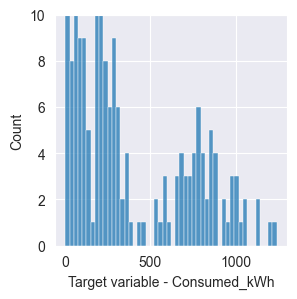

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

TARGET_COLUMN = column_lists["target_columns"][0]

# Plot the distribution of the target variable
plt.figure(figsize=(3, 3))
sns.histplot(data=df, x=TARGET_COLUMN, bins=50, kde=False)
plt.ylim(0,10)

# Add labels
plt.xlabel(f'Target variable - {TARGET_COLUMN}')
plt.ylabel('Count')

In [33]:
# filter df to only include rows where the target variable is greater than 3500
df_check = df[df[f"{TARGET_COLUMN}"] > 3500]
df_check

,PC6,Date,PC6_WeekIndex,Consumed_kWh,Blocked_kWh,MaxPower,number_of_chargers,WeekIndex,SinWeekOfYear,CosWeekOfYear,SinMonthOfYear,CosMonthOfYear,ChargeSocket_ID_count,ConnectionTimeHours,power,effective_charging_hrs,MaxOccupancy,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,PC4,District,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,Consumed_kWh_lag,Blocked_kWh_lag
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Text(0, 0.5, 'Count')

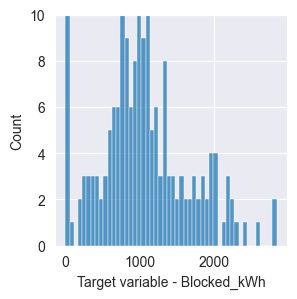

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

TARGET_COLUMN = column_lists["target_columns"][1]

# Plot the distribution of the target variable
plt.figure(figsize=(3, 3))
sns.histplot(data=df, x=TARGET_COLUMN, bins=50, kde=False)
plt.ylim(0, 10)

# Add labels
plt.xlabel(f'Target variable - {TARGET_COLUMN}')
plt.ylabel('Count')

In [35]:
# filter df to only include rows where the target variable is greater than 3500
df_check = df[df[f"{TARGET_COLUMN}"] > 20000]
df_check

,PC6,Date,PC6_WeekIndex,Consumed_kWh,Blocked_kWh,MaxPower,number_of_chargers,WeekIndex,SinWeekOfYear,CosWeekOfYear,SinMonthOfYear,CosMonthOfYear,ChargeSocket_ID_count,ConnectionTimeHours,power,effective_charging_hrs,MaxOccupancy,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,PC4,District,District-encoded_0,District-encoded_1,District-encoded_2,District-encoded_3,PC6-encoded_0,PC6-encoded_1,PC6-encoded_2,PC6-encoded_3,PC6-encoded_4,PC6-encoded_5,PC6-encoded_6,PC6-encoded_7,PC6-encoded_8,PC6-encoded_9,PC6-encoded_10,PC6-encoded_11,PC6-encoded_12,PC6-encoded_13,PC6-encoded_14,PC4-encoded_0,PC4-encoded_1,PC4-encoded_2,PC4-encoded_3,PC4-encoded_4,PC4-encoded_5,PC4-encoded_6,Engie,Ecotap,Pitpoint,WDS,Nuon,EvBox,Equans,Allego,Vattenfall,Total,FastChargerNumber,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,effective_charging_hrs0-1,effective_charging_hrs1-2,effective_charging_hrs2-3,effective_charging_hrs3-4,effective_charging_hrs4-5,effective_charging_hrs5-6,effective_charging_hrs6-7,effective_charging_hrs7-8,effective_charging_hrs8-9,effective_charging_hrs9-10,effective_charging_hrs10-11,effective_charging_hrs11-12,effective_charging_hrs12-13,effective_charging_hrs13-14,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24,bus_count,metro_count,tram_count,parking_count,traffic_area,built_up_area,semi_built_up_area,recreational_area,agrarian_area,forest_nature_are,water_body_area,December 2022_EV,December 2022_hybrid,2022_0_to_10,2022_10_to_20,2022_20_to_30,2022_30_to_40,2022_40_to_50,2019.0_household,2019.0_income_1_to_40_percent,2019.0_income_41_to_80_percent,2019.0_income_81_to_100_percent,2019.0_income_average,2019.0_assets_1_to_40_percent,2019.0_assets_41_to_80_percent,2019.0_assets_81_to_100_percent,2019.0_assets_average,2019.0_Gemiddelde SES WOA totaalscore,Consumed_kWh_lag,Blocked_kWh_lag
RowIndex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
